### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))
            self.added_points.append(PointsCollection([], color = 'orange'))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.added_points[-1].add_points([new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
                self.added_points[-1].add_points([new_point])
                self.draw(autoscaling = False)
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Zadawanie odcinków oraz generowanie losowych odcinków

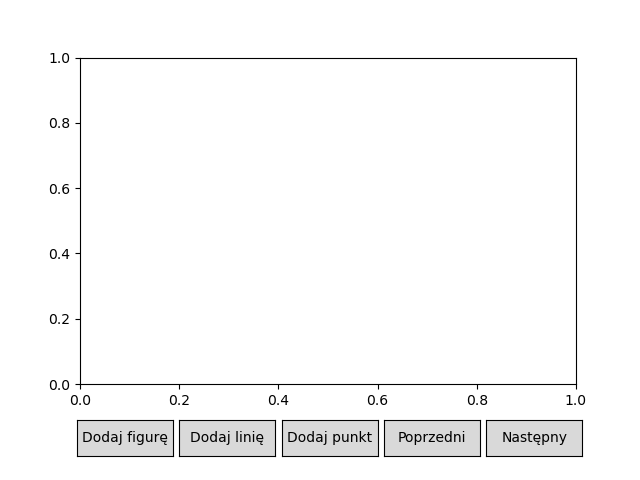

In [12]:
%matplotlib widget
bound_points = PointsCollection([(0, 0), (100, 0), (100, 100), (0, 100)], alpha = 0.0)
eps = 10 ** -12

plot = Plot(points = [bound_points])
plot.draw()

In [5]:
import json
from random import uniform
eps = 10 ** -12

def get_lines_from_plot(plot):
    return plot.get_added_lines()[0].lines

def save_lines_to_file(lines, name):
    jsonString = json.dumps(lines)
    with open(name + '.json', 'w') as f:
        f.write(jsonString)
    
def generate_random_lines(n, bound_x, bound_y):
    lines = []
    
    for _ in range(n):
        p1 = (0, 0)
        p2 = (0, 0)
        while (p1[0] + eps > p2[0] and p1[0] - eps < p2[0]) or not can_be_added(p1, p2, lines):
            p1 = (uniform(0, bound_x), uniform(0, bound_y))
            p2 = (uniform(0, bound_x), uniform(0, bound_y))
        lines.append([p1, p2])

    return lines

def get_saved_lines(name):
    with open(name + '.json', 'r') as f:
        jsonContent = f.read()
    lines = json.loads(jsonContent)
    #print(lines)
    return lines

def visualize_lines(lines, intersect_points):
    bound_points = PointsCollection([(0, 0), (100, 0), (100, 100), (0, 100)], alpha = 0.0)
    points = []
    for line in lines:
        a = line[0]
        b = line[1]
        points.append(a)
        points.append(b)
    plot = Plot(points = [bound_points] + [PointsCollection(points, color = 'orange')]
        + [PointsCollection(intersect_points, color = 'red')], lines = [LinesCollection(lines)])
    plot.draw()

def can_be_added(p1, p2, lines):
    for line in lines:
        if (p2[0] - eps < line[1][0] and p2[0] + eps > line[1][0]) or \
                (p1[0] - eps < line[1][0] and p1[0] + eps > line[1][0]) or \
                    (p2[0] - eps < line[0][0] and p2[0] + eps > line[0][0]) or \
                        (p1[0] - eps < line[0][0] and p1[0] + eps > line[0][0]) :
            return False
    return True


""" Przykładowe wywołania wynkcji

#lines = get_lines_from_plot(plot)
#lines = get_saved_lines('not2')
#lines = get_saved_lines('lines1')
#lines = generate_random_lines(15, 100, 100)
#save_lines_to_file(lines, 'lab1')
#visualize_lines(lines)

"""
    

### Funkcje pomocnicze i wykorzystane klasy

In [6]:
from sortedcontainers import SortedSet
eps = 10 ** -12

class Event:
    def __init__(self, x, type, idx1, idx2):
        self.x = x
        self.type = type
        self.idx1 = idx1
        self.idx2 = idx2
        
        if type == 'I':
            self.idx1 = min(idx1, idx2)
            self.idx2 = max(idx1, idx2)

    def __eq__(self, other):
        return self.type == other.type \
            and self.idx1 == other.idx1 and self.idx2 == other.idx2
    
    def __gt__(self, other):
        return self.x > other.x

    def __hash__(self):
        return hash(self.type) + hash(self.idx1) + hash(self.idx2)

class Line:
    def __init__(self, idx, p1, p2):
        self.idx = idx
        self.p1 = p1
        self.p2 = p2
        self.a = (p2[1] - p1[1]) / (p2[0] - p1[0])
        self.b = p1[1] - p1[0] * self.a

    def update(x):
        Line.x = x
        
    def __eq__(self, other):
        return self.idx == other.idx
    
    def __gt__(self, other):
        return Line.x * self.a + self.b > Line.x * other.a + other.b
    
    def __hash__(self):
        return hash(self.idx)

def create_lines_representation(lines):
    new_lines = []

    for i in range(len(lines)):
        if lines[i][1][0] < lines[i][0][0]:
            new_lines.append(Line(i, lines[i][1], lines[i][0]))
        else:
            new_lines.append(Line(i, lines[i][0], lines[i][1]))

    return new_lines

def get_intersection_point(line1, line2, x):
    ix = (line1.b - line2.b) / (line2.a - line1.a)

    if ix > max(line1.p1[0], line2.p1[0]) - eps and ix < min(line1.p2[0], line2.p2[0]) + eps and ix >= x:
        return (ix, line1.a * ix + line1.b)
    else:
        return None

### Algorytm zamiatania do sprawdzania czy chociaż jedna para odcinków się przecina

Główny algorytm

In [7]:
def any_intersection(lines):
    lines = create_lines_representation(lines)
    eventQueue = SortedSet()
    stateSet = SortedSet()
    points = []

    for i in range(len(lines)):
        eventQueue.add(Event(lines[i].p1[0], 'B', i, None))
        eventQueue.add(Event(lines[i].p2[0], 'E', i, None))

    while len(eventQueue) > 0:
        e = eventQueue.pop(0)
        Line.update(e.x)

        if e.type == 'B':
            point = handleBeginAny(eventQueue, stateSet, lines[e.idx1], e.x)
        elif e.type == 'E':
            point = handleEndAny(eventQueue, stateSet, lines[e.idx1], e.x)

        if point:
            return True
    return False

def handleBeginAny(eventQueue, stateSet, line, x):
    stateSet.add(line)
    
    i = stateSet.index(line)
    if i + 1 < len(stateSet) and get_intersection_point(stateSet[i], stateSet[i + 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i + 1], x)
        return (ix, iy)
    if i - 1 >= 0 and get_intersection_point(stateSet[i], stateSet[i - 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i - 1], x)
        return (ix, iy)
    return None


def handleEndAny(eventQueue, stateSet, line, x):
    i = stateSet.index(line)

    if i + 1 < len(stateSet) and i - 1 >= 0:
        upper = stateSet[i + 1]
        lower = stateSet[i - 1]
        stateSet.remove(line)
        i = stateSet.index(upper)
        j = stateSet.index(lower)

        if get_intersection_point(stateSet[i], stateSet[j], x):
            ix, iy = get_intersection_point(stateSet[i], stateSet[j], x)
            return ix, iy
    else:
        stateSet.remove(line)
    return None

Wizualizacja algorytmu

In [8]:
bound_points = PointsCollection([(0, 0), (100, 0), (100, 100), (0, 100)], alpha = 0.0)
def visualize_any_intersection(l):
    bound_point = PointsCollection([(0, 0), (100, 100)])
    scenes = []
    active_lines = []
    event_points = []

    lines = create_lines_representation(l)
    eventQueue = SortedSet()
    stateSet = SortedSet()
    points = []

    for i in range(len(lines)):
        eventQueue.add(Event(lines[i].p1[0], 'B', i, None))
        eventQueue.add(Event(lines[i].p2[0], 'E', i, None))

    event_points = [lines[e.idx1].p1 for e in eventQueue] + [lines[e.idx1].p2 for e in eventQueue]
    scenes.append(Scene(points = [PointsCollection(event_points, color = 'orange')] + [bound_points], \
                        lines = [LinesCollection(l)]))

    while len(eventQueue) > 0:
        e = eventQueue.pop(0)

        Line.update(e.x)

        if e.type == 'B':
            point = handleBeginAny(eventQueue, stateSet, lines[e.idx1], e.x)
        elif e.type == 'E':
            point = handleEndAny(eventQueue, stateSet, lines[e.idx1], e.x)

        if point:
            active_lines = [[l.p1, l.p2] for l in stateSet]
            scenes.append(Scene(points = [PointsCollection(event_points, color = 'orange')] + \
                                [bound_points] + [PointsCollection([point], color = 'red')], \
                        lines = [LinesCollection(l)] + [LinesCollection(active_lines, color = 'black')] + \
                                [LinesCollection([[(e.x, 0), (e.x, 100)]], color = 'yellow')]))
            return scenes

        active_lines = [[l.p1, l.p2] for l in stateSet]
        scenes.append(Scene(points = [PointsCollection(event_points, color = 'orange')] + \
                                [bound_points], \
                        lines = [LinesCollection(l)] + [LinesCollection(active_lines, color = 'black')] + \
                                [LinesCollection([[(e.x, 0), (e.x, 100)]], color = 'yellow')]))

    return scenes

def handleBeginAny(eventQueue, stateSet, line, x):
    stateSet.add(line)
    
    i = stateSet.index(line)
    if i + 1 < len(stateSet) and get_intersection_point(stateSet[i], stateSet[i + 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i + 1], x)
        return (ix, iy)
    if i - 1 >= 0 and get_intersection_point(stateSet[i], stateSet[i - 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i - 1], x)
        return (ix, iy)
    return None


def handleEndAny(eventQueue, stateSet, line, x):
    i = stateSet.index(line)

    if i + 1 < len(stateSet) and i - 1 >= 0:
        upper = stateSet[i + 1]
        lower = stateSet[i - 1]
        stateSet.remove(line)
        i = stateSet.index(upper)
        j = stateSet.index(lower)

        if get_intersection_point(stateSet[i], stateSet[j], x):
            ix, iy = get_intersection_point(stateSet[i], stateSet[j], x)
            return ix, iy
    else:
        stateSet.remove(line)
    return None

### Algorytm zamiatania do znajdowanie wszytskich przecięć odcinków

Główny algorytm do znajdowania wszystkich przecięć miedzy odcinkami

In [9]:

def find_intersections(lines):
    lines = create_lines_representation(lines)
    eventQueue = SortedSet()
    stateSet = SortedSet()
    points = []

    for i in range(len(lines)):
        eventQueue.add(Event(lines[i].p1[0], 'B', i, None))
        eventQueue.add(Event(lines[i].p2[0], 'E', i, None))

    while len(eventQueue) > 0:
        e = eventQueue.pop(0)

        if e.type == 'B':
            Line.update(e.x)
            handleBegin(eventQueue, stateSet, lines[e.idx1], e.x)
        elif e.type == 'E':
            Line.update(e.x)
            handleEnd(eventQueue, stateSet, lines[e.idx1], e.x)
        else:
            points.append(get_intersection_point(lines[e.idx1], lines[e.idx2], e.x))
            handleIntersect(eventQueue, stateSet, lines[e.idx1], lines[e.idx2], e.x)

    return points

def handleBegin(eventQueue, stateSet, line, x):
    stateSet.add(line)
    
    i = stateSet.index(line)
    if i + 1 < len(stateSet) and get_intersection_point(stateSet[i], stateSet[i + 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i + 1], x)
        eventQueue.add(Event(ix, 'I', stateSet[i].idx, stateSet[i + 1].idx))
    if i - 1 >= 0 and get_intersection_point(stateSet[i], stateSet[i - 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i - 1], x)
        eventQueue.add(Event(ix, 'I', stateSet[i].idx, stateSet[i - 1].idx))


def handleEnd(eventQueue, stateSet, line, x):
    i = stateSet.index(line)

    if i + 1 < len(stateSet) and i - 1 >= 0:
        upper = stateSet[i + 1]
        lower = stateSet[i - 1]
        stateSet.remove(line)
        i = stateSet.index(upper)
        j = stateSet.index(lower)

        if get_intersection_point(stateSet[i], stateSet[j], x):
            ix, iy = get_intersection_point(stateSet[i], stateSet[j], x)
            eventQueue.add(Event(ix, 'I', stateSet[i].idx, stateSet[j].idx))
    else:
        stateSet.remove(line)


def handleIntersect(eventQueue, stateSet, line1, line2, x):

    stateSet.remove(line1)
    stateSet.remove(line2)

    Line.update(x + eps)
    stateSet.add(line1)
    stateSet.add(line2)

    i = stateSet.index(line1)
    j = stateSet.index(line2)

    if i > j:
        i, j = j, i

    if j + 1 < len(stateSet) and get_intersection_point(stateSet[j], stateSet[j + 1], x):
        ix, iy = get_intersection_point(stateSet[j], stateSet[j + 1], x)
        eventQueue.add(Event(ix, 'I', stateSet[j].idx, stateSet[j + 1].idx))

    if i - 1 >= 0 and get_intersection_point(stateSet[i], stateSet[i - 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i - 1], x)
        eventQueue.add(Event(ix, 'I', stateSet[i].idx, stateSet[i - 1].idx))

Wizualizacja algorytmu do znajdowania wszytskich przecięć

In [12]:
bound_points = PointsCollection([(0, 0), (100, 0), (100, 100), (0, 100)], alpha = 0.0)
def visualize_find_intersections(l):
    bound_point = PointsCollection([(0, 0), (100, 100)])
    scenes = []
    active_lines = []
    event_points = []

    lines = create_lines_representation(l)
    eventQueue = SortedSet()
    stateSet = SortedSet()
    points = []

    for i in range(len(lines)):
        eventQueue.add(Event(lines[i].p1[0], 'B', i, None))
        eventQueue.add(Event(lines[i].p2[0], 'E', i, None))

    event_points = [lines[e.idx1].p1 for e in eventQueue] + [lines[e.idx1].p2 for e in eventQueue]
    scenes.append(Scene(points = [PointsCollection(event_points, color = 'orange')] + [bound_points], \
                        lines = [LinesCollection(l)]))

    while len(eventQueue) > 0:
        e = eventQueue.pop(0)

        p = []
        if e.type == 'B':
            Line.update(e.x)

            handleBeginVis(eventQueue, stateSet, lines[e.idx1], e.x, points)
        elif e.type == 'E':
            Line.update(e.x)
            handleEndVis(eventQueue, stateSet, lines[e.idx1], e.x, points)
        else:
            handleIntersectVis(eventQueue, stateSet, lines[e.idx1], lines[e.idx2], e.x, points)
        
        active_lines = [[l.p1, l.p2] for l in stateSet]
        scenes.append(Scene(points = [PointsCollection(event_points, color = 'orange')] + \
                                [PointsCollection([p for p in points], color = 'red')] + [bound_points], \
                        lines = [LinesCollection(l)] + [LinesCollection(active_lines, color = 'black')] + \
                                [LinesCollection([[(e.x, 0), (e.x, 100)]], color = 'yellow')]))

    return points, scenes

def handleBeginVis(eventQueue, stateSet, line, x, points):
    stateSet.add(line)
    
    i = stateSet.index(line)
    if i + 1 < len(stateSet) and get_intersection_point(stateSet[i], stateSet[i + 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i + 1], x)
        eventQueue.add(Event(ix, 'I', stateSet[i].idx, stateSet[i + 1].idx))
        points.append((ix, iy))
    if i - 1 >= 0 and get_intersection_point(stateSet[i], stateSet[i - 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i - 1], x)
        eventQueue.add(Event(ix, 'I', stateSet[i].idx, stateSet[i - 1].idx))
        points.append((ix, iy))


def handleEndVis(eventQueue, stateSet, line, x, points):
    i = stateSet.index(line)

    if i + 1 < len(stateSet) and i - 1 >= 0:
        upper = stateSet[i + 1]
        lower = stateSet[i - 1]
        stateSet.remove(line)
        i = stateSet.index(upper)
        j = stateSet.index(lower)

        if get_intersection_point(stateSet[i], stateSet[j], x):
            ix, iy = get_intersection_point(stateSet[i], stateSet[j], x)
            eventQueue.add(Event(ix, 'I', stateSet[i].idx, stateSet[j].idx))
            points.append((ix, iy))
    else:
        stateSet.remove(line)


def handleIntersectVis(eventQueue, stateSet, line1, line2, x, points):

    stateSet.remove(line1)
    stateSet.remove(line2)

    Line.update(x + eps)
    stateSet.add(line1)
    stateSet.add(line2)

    i = stateSet.index(line1)
    j = stateSet.index(line2)

    if i > j:
        i, j = j, i

    if j + 1 < len(stateSet) and get_intersection_point(stateSet[j], stateSet[j + 1], x):
        ix, iy = get_intersection_point(stateSet[j], stateSet[j + 1], x)
        eventQueue.add(Event(ix, 'I', stateSet[j].idx, stateSet[j + 1].idx))
        points.append((ix, iy))

    if i - 1 >= 0 and get_intersection_point(stateSet[i], stateSet[i - 1], x):
        ix, iy = get_intersection_point(stateSet[i], stateSet[i - 1], x)
        eventQueue.add(Event(ix, 'I', stateSet[i].idx, stateSet[i - 1].idx))
        points.append((ix, iy))

    

### Rozwiązanie

Wykorzystanie algorytmu do znajdywania wszytskich przecięć

Ilość przecięć:  36


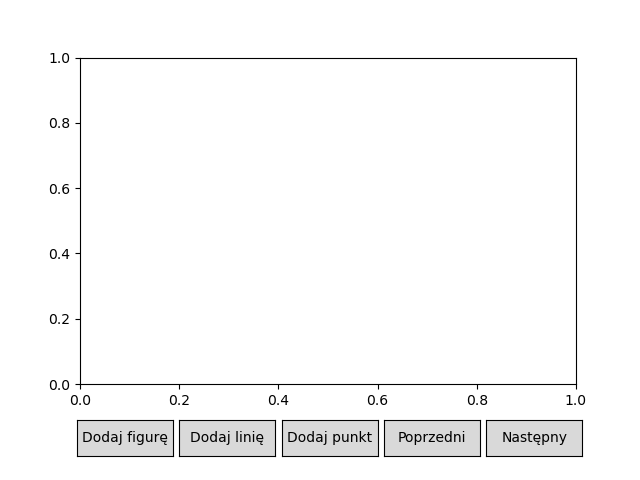

In [13]:
%matplotlib widget


lines = get_saved_lines('lab1') #należy dodac nazwe pliku z zapisanymi odcinkami
points = find_intersections(lines)
print("Ilość przecięć: ", len(points))

points, scenes = visualize_find_intersections(lines)
plot = Plot(scenes = scenes)
plot.draw()

Wykorzystanie algorytmu do sprawdzania czy istieje chociaż jedno przecięcie

Czy się przecinają:  True


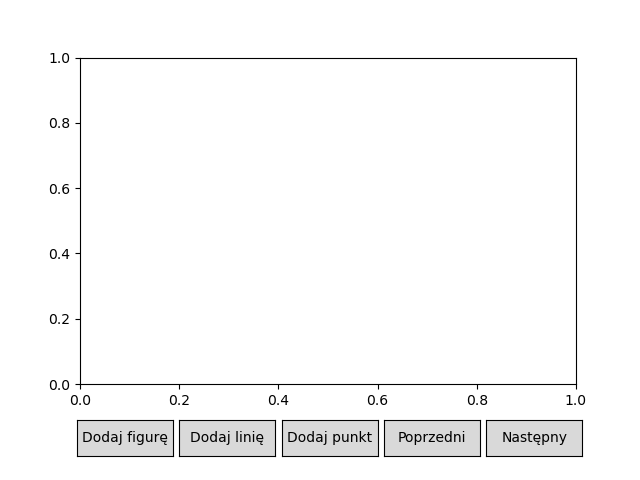

In [14]:
%matplotlib widget

lines = get_saved_lines('lab1') #nalezy dodac nazwe pliku z zapisanymi odcinkami
print("Czy się przecinają: ", any_intersection(lines))

scenes = visualize_any_intersection(lines)
plot = Plot(scenes = scenes)
plot.draw()
